### Real time deployment of the machine learning algorithms for predicting the magnetic flux rope structure in coronal mass ejections

This is a code adapted for real time Bz prediction from the Reiss et al. 2021 Space Weather paper.
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021SW002859

This notebook is used for real time deployment.


### Update
last update 2024 Sep 12.

### Ideas

- deploy in real time for data files for STEREO-A and NOAA RTSW  under folder data_path:
"stereoa_beacon_gsm_last_35days_now.p" and "noaa_rtsw_last_35files_now.p"
- read in ML model trained with the notebooks mfrpred_real_bz (done), mfpred_real_btot (need to update)

- continous deployment, look at results during CMEs
- assess progression of results in real time as more of the CME is seen
- needs different trained model for each timestep, i.e. for different hours after sheath and MFR entry?

- add general Bz distribution plots here at the end


### Future
- forecast of the cumulative southward Bz during a geomagnetic storm?
- start at time of shock, and then decrease the error bars with time
- correlate with Dst

pattern recognition
https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016SW001589

bz after shocks
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018SW002056

#### Authors: 
M.A. Reiss (1), C. Möstl (2), R.L. Bailey (3), and U. Amerstorfer (2), Emma Davies (2), Eva Weiler (2)

(1) NASA CCMC, 
(2) Austrian Space Weather Office, GeoSphere Austria
(3) Conrad Observatory, GeoSphere Austria


In [74]:

########### controls

print()
print('started mfrpred_deploy.py')


################

import time

#test execution times
t0all = time.time()


import os
import sys
import copy
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import cm
import numpy as np
import pickle
from scipy import stats
import scipy.io
import time
import datetime

# Visualisation
import sunpy.time
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from sunpy.time import parse_time

# Machine learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor, RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

os.system('jupyter nbconvert --to script mfrpred_deploy.ipynb')    

#get data paths
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml




started mfrpred_deploy.py


[NbConvertApp] Converting notebook mfrpred_deploy.ipynb to script
[NbConvertApp] Writing 10047 bytes to mfrpred_deploy.py


## load real time data

In [75]:
filenoaa='noaa_rtsw_last_35files_now.p'
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

file_sta_beacon_gsm='stereoa_beacon_gsm_last_35days_now.p'  
[sta,hsta]=pickle.load(open(data_path+file_sta_beacon_gsm, "rb" ) )  

print('real time NOAA RTSW and STEREO-A data loaded')

#cutout last 10 days
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 

ind=np.where(noaa.time > start)[0][0]
noaa=noaa[ind:]

ind2=np.where(sta.time > start)[0][0]
sta=sta[ind2:]

real time NOAA RTSW and STEREO-A data loaded


(19968.478786884978, 19978.478786885255)

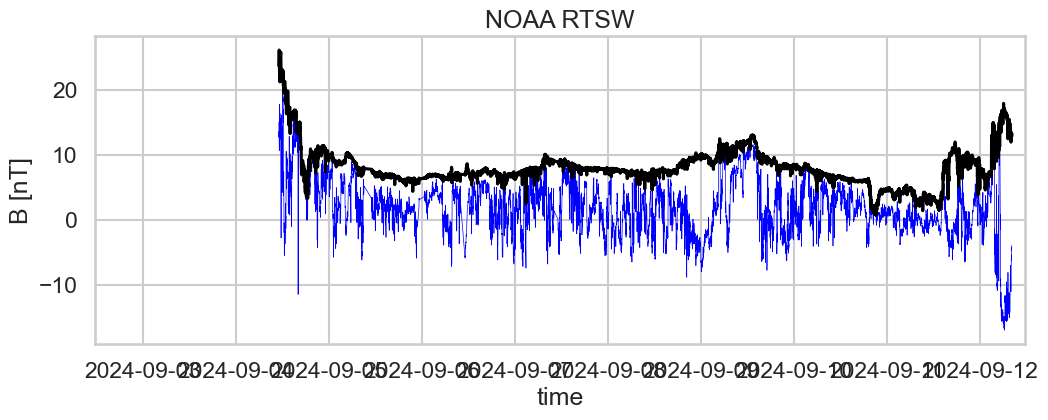

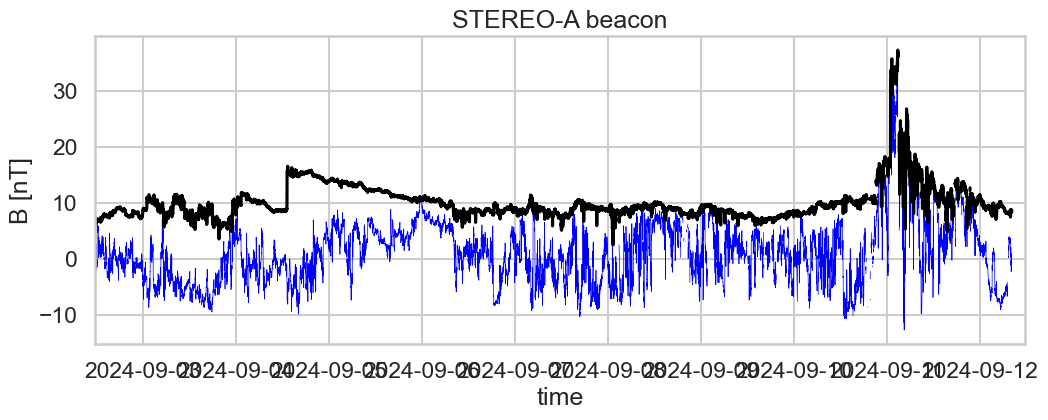

In [76]:
###plot NOAA
plt.figure(1,figsize=(12, 4))
plt.plot(noaa.time,noaa.bz, '-b',lw=0.5)
plt.plot(noaa.time,noaa.bt,'-k')

plt.title("NOAA RTSW")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)

#plot STEREO-A

plt.figure(2,figsize=(12, 4))
plt.plot(sta.time,sta.bz, '-b',lw=0.5)
plt.plot(sta.time,sta.bt,'-k')

plt.title("STEREO-A beacon")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)


(19978.06212472287, 19978.47879138986)

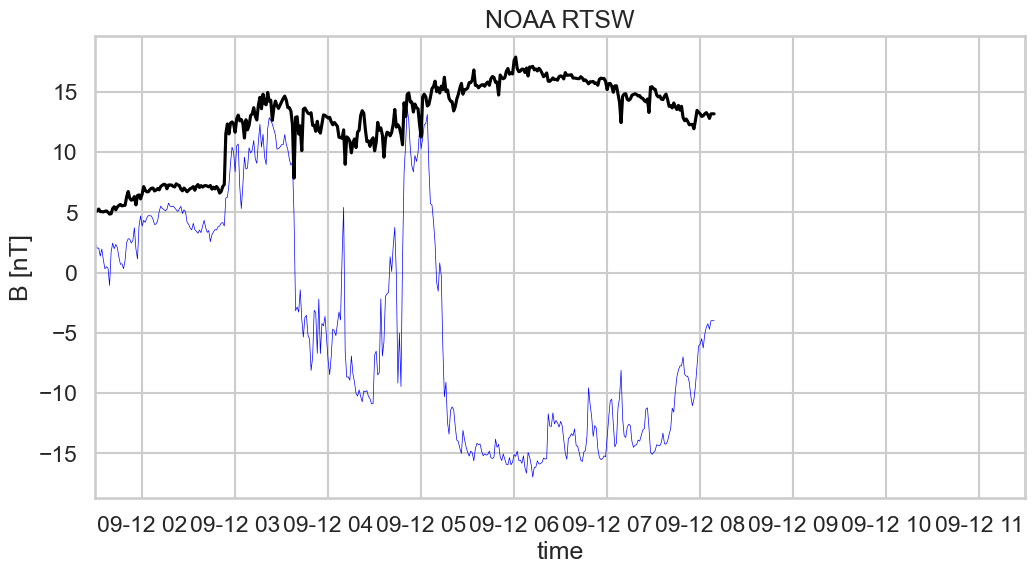

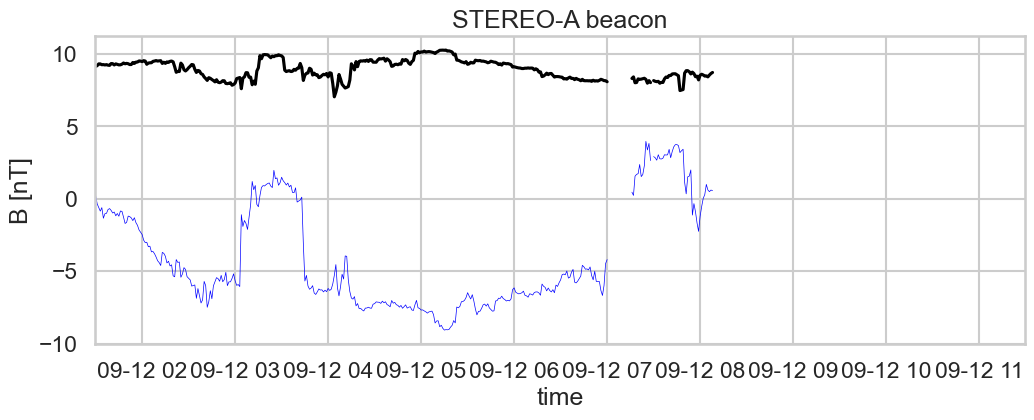

In [77]:

sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(12,6),dpi=100)
#ax1 = plt.subplot(111) 


#cutout last 10 hours, e.g. sheath is over and flux rope starts
start=datetime.datetime.utcnow() - datetime.timedelta(hours=10)
end=datetime.datetime.utcnow() 

ind=np.where(noaa.time > start)[0][0]
noaa_cut=noaa[ind:]

ind2=np.where(sta.time > start)[0][0]
sta_cut=sta[ind2:]

###plot NOAA
plt.figure(1,figsize=(12, 4))
plt.plot(noaa_cut.time,noaa_cut.bz, '-b',lw=0.5)
plt.plot(noaa_cut.time,noaa_cut.bt,'-k')

plt.title("NOAA RTSW")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)

#plot STEREO-A

plt.figure(2,figsize=(12, 4))
plt.plot(sta_cut.time,sta_cut.bz, '-b',lw=0.5)
plt.plot(sta_cut.time,sta_cut.bt,'-k')

plt.title("STEREO-A beacon")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)



### load ML model

In [78]:

#what the model numbers mean
#model1 = models['lr'] 
#model2 = models['rfr'] 
#model3 = models['gbr'] 

feature_hours=10
[model1,model2,model3]=pickle.load(open('trained_models/bz_'+str(feature_hours)+'h_model.p','rb'))


print()
print('ML model loaded')

#model1.predict()
model2


#y_pred1 = model1.predict(X_test)

#y_pred1 sind die Bz predictions




ML model loaded


RandomForestRegressor(max_depth=5, min_samples_split=4, n_estimators=300)

### Apply ML model


In [79]:
## how to apply, first calculate features from current data? and then put into model

#feature space - map to model, get output

print()
print('ML model to be run on real time data')



ML model to be run on real time data


### Make output data files and plots

In [80]:
print()
print('results')
print()


results



### General Bz overview plots

In [81]:
##load ICME catalog

[ic,header,parameters] = pickle.load(open('data/ICMECAT/HELIO4CAST_ICMECAT_v22_pandas.p', "rb" ))

print()
print('ICMECAT loaded')

# Spacecraft
isc = ic.loc[:,'sc_insitu'] 

# Shock arrival or density enhancement time
icme_start_time = ic.loc[:,'icme_start_time']
icme_start_time_num = date2num(np.array(icme_start_time))

# Start time of the magnetic obstacle (mo)
mo_start_time = ic.loc[:,'mo_start_time']
mo_start_time_num = date2num(np.array(mo_start_time))

# End time of the magnetic obstacle (mo)
mo_end_time = ic.loc[:,'mo_end_time']
mo_end_time_num = date2num(np.array(mo_end_time))

#get indices for each target
wini=np.where(ic.sc_insitu=='Wind')[0]
stai=np.where(ic.sc_insitu=='STEREO-A')[0]
stbi=np.where(ic.sc_insitu=='STEREO-B')[0]
pspi=np.where(ic.sc_insitu=='PSP')[0]
soloi=np.where(ic.sc_insitu=='SolarOrbiter')[0]
bepii=np.where(ic.sc_insitu=='BepiColombo')[0]
ulyi=np.where(ic.sc_insitu=='Ulysses')[0]
messi=np.where(ic.sc_insitu=='Messenger')[0]
vexi=np.where(ic.sc_insitu=='VEX')[0]


ICMECAT loaded


In [82]:
ic.keys()

Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')



saved plots/icme_bz_time.png




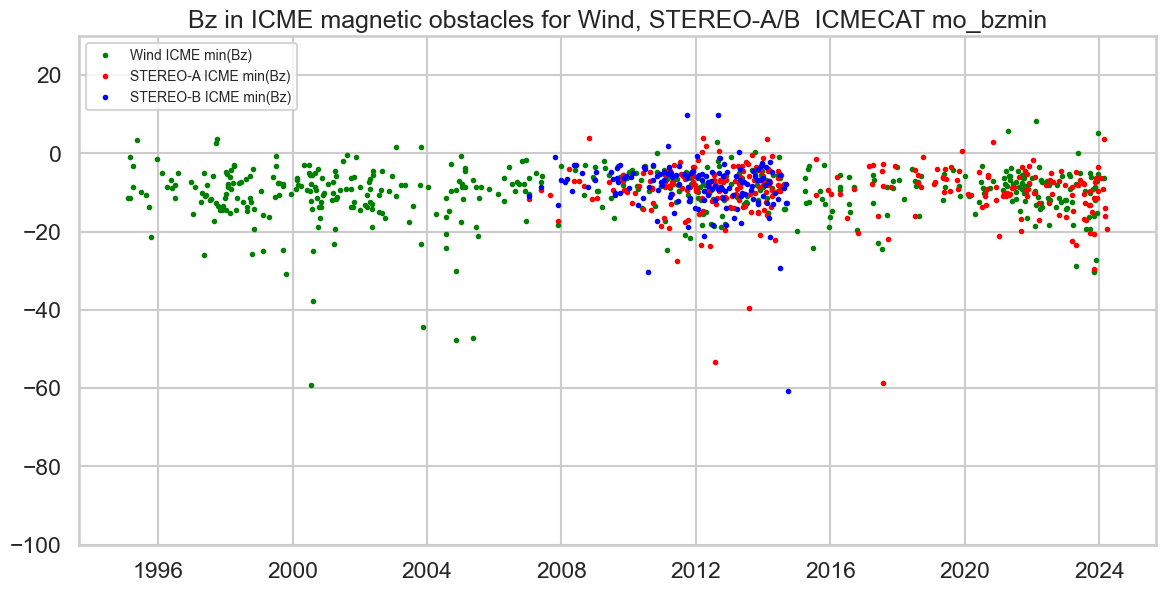

In [83]:
##plot for minimum Bz vs time

sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(12,6),dpi=100)
ax1 = plt.subplot(111) 

ax1.plot(ic['icme_start_time'][wini],ic['mo_bzmin'][wini],'og',markersize=3,label='Wind ICME min(Bz)')
ax1.plot(ic['icme_start_time'][stai],ic['mo_bzmin'][stai],'or',markersize=3,label='STEREO-A ICME min(Bz)')
ax1.plot(ic['icme_start_time'][stbi],ic['mo_bzmin'][stbi],'ob',markersize=3,label='STEREO-B ICME min(Bz)')
ax1.set_ylim(-100,30)
plt.legend(fontsize=10,loc=2)
plt.tight_layout()
plt.title('Bz in ICME magnetic obstacles for Wind, STEREO-A/B  ICMECAT mo_bzmin')

plt.savefig('plots/icme_bz_time.png')


print()
print()
print('saved plots/icme_bz_time.png')
print()
print()

### duration of ICMEs

mean ICME_duration at Wind [hours] 29.61 +/- 15.13
mean sheath_duration at Wind [hours] 6.85 +/- 6.87
mean MO_duration at Wind [hours] 22.76 +/- 12.49


saved plots/icme_mo_duration.png




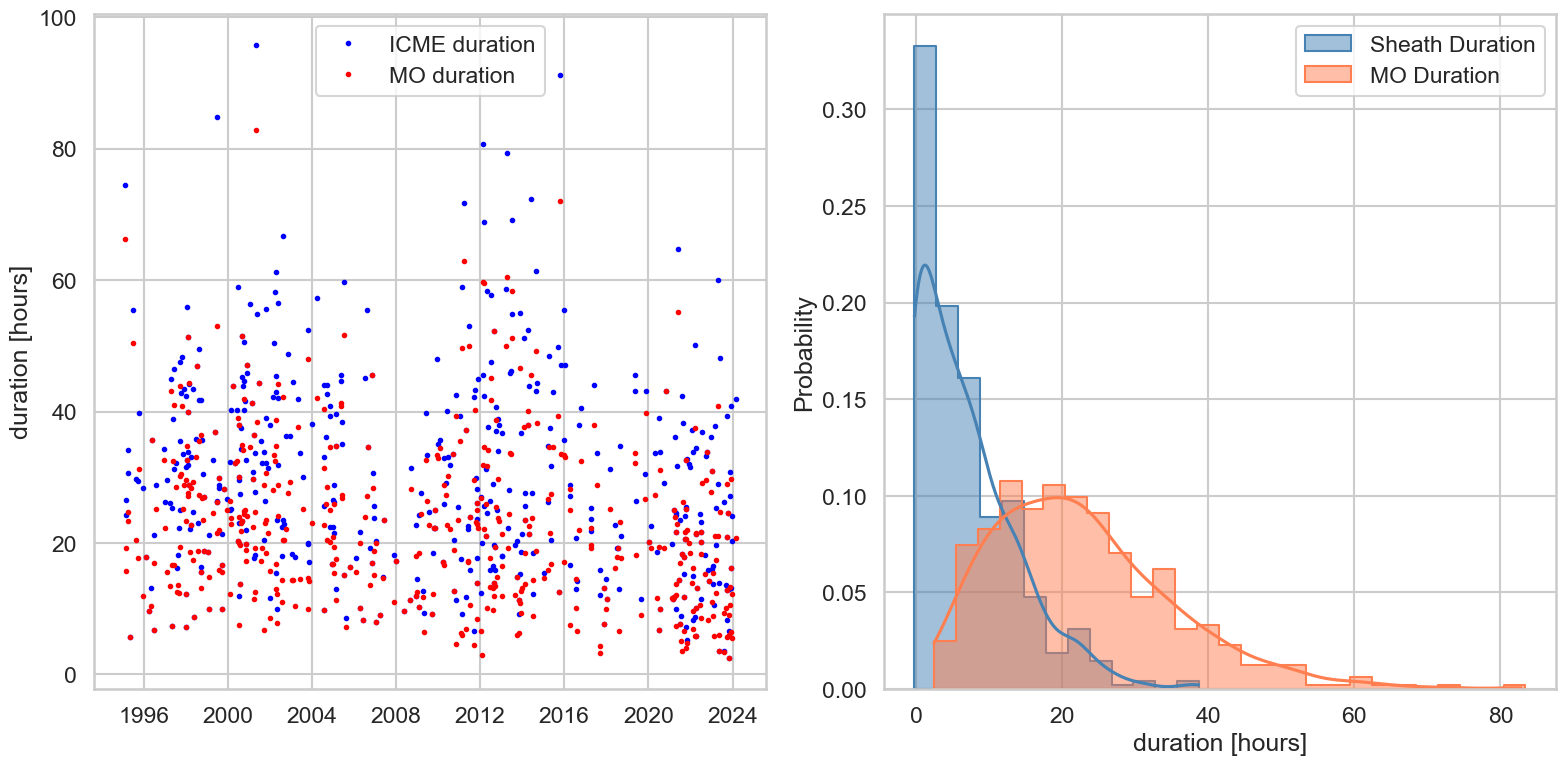

In [84]:
sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(16,8),dpi=100)
ax1 = plt.subplot(121) 

ax1.plot(ic['icme_start_time'][wini],ic['icme_duration'][wini],'ob',markersize=3,label='ICME duration')
ax1.plot(ic['icme_start_time'][wini],ic['mo_duration'][wini],'or',markersize=3,label='MO duration')
plt.legend()
ax1.set_ylabel('duration [hours]')

ax2 = plt.subplot(122) 
sns.histplot(ic.loc[wini,'icme_duration']-ic.loc[wini,'mo_duration'],label='Sheath Duration',color='steelblue',kde=True,stat='probability', element='step',binwidth = 3)
sns.histplot(ic.loc[wini,'mo_duration'],label='MO Duration',color='coral',kde=True,stat='probability', element='step',binwidth = 3)
plt.legend()
ax2.set_xlabel('duration [hours]')


print('mean ICME_duration at Wind [hours]',np.round(np.nanmean(ic['icme_duration'][wini]),2),'+/-',np.round(np.nanstd(ic['icme_duration'][wini]),2))

print('mean sheath_duration at Wind [hours]',np.round(np.nanmean(ic['icme_duration'][wini]-ic['mo_duration'][wini]),2), '+/-',np.round(np.nanstd(ic['icme_duration'][wini]-ic['mo_duration'][wini]),2))

print('mean MO_duration at Wind [hours]',np.round(np.nanmean(ic['mo_duration'][wini]),2),'+/-',np.round(np.nanstd(ic['mo_duration'][wini]),2))

plt.tight_layout()

plt.savefig('plots/icme_mo_duration.png')
plt.savefig('plots/icme_mo_duration.pdf')


print()
print()
print('saved plots/icme_mo_duration.png')
print()
print()


In [85]:
t1all = time.time()

print(' ')
print('------------------')
print('Runtime for full high frequency data update:', np.round((t1all-t0all)/60,2), 'minutes')
print('------------------')

 
------------------
Runtime for full high frequency data update: 0.06 minutes
------------------
